In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk_temp/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_test_adj.npz
airport_word2vec_128_embs.npy
airport_word2vec_None_deepwalk_deepwalk_em

In [4]:
y = snakemake_utils.get_dataset("polblog").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk_temp/polblog/'

DIRS = ['polblog_one/', 'polblog_two/', 'polblog_three/', 'polblog_four/', 'polblog_five/']
DATASET = 'polblog'

model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy",
    
    "word2vec": "_word2vec_128_embs.npy",
    "word2vec+deepwalk+random": "_word2vec_None_deepwalk_deepwalk_embs.npy"
    
}
M = list(model_to_embs.keys())


TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk_temp/polblog/polblog_one/polblog_test_adj.npz'
NUM_NODES=1224
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# word2vec

In [8]:
model = "word2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


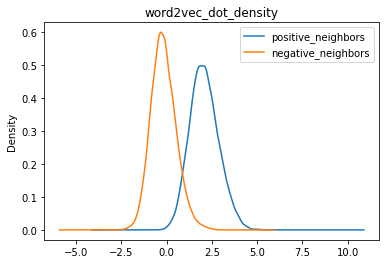

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6200.38it/s]


((6120, 2), 0.004016077668200292, 0.9830925997224349, 0.27446417846612314)

# word2vec+deepwalk+random

In [11]:
model = "word2vec+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


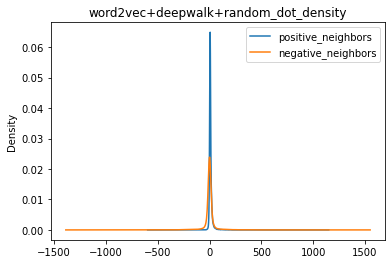

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5807.04it/s]


((6120, 2), 0.002090444147550872, 0.7098698090322617, 0.16094800338836068)

# deepwalk

In [14]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


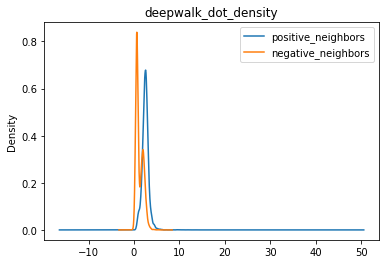

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5573.77it/s]


((6104, 2), 0.004879035413453508, 0.8822039274763456, 0.2927547096109085)

# node2vec

In [17]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


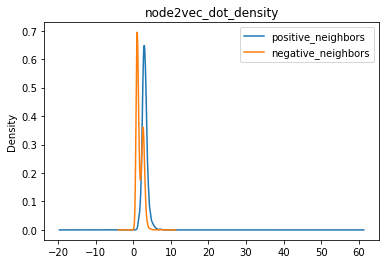

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5244.28it/s]


((6114, 2), 0.00479373872687331, 0.8740672999924439, 0.2923689397459116)

# fairwalk+deepwalk

In [20]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


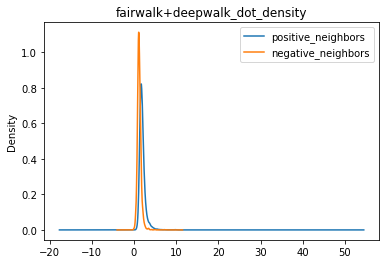

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6183.60it/s]


((6120, 2), 0.003558708446888458, 0.8575439931136051, 0.23351528990797066)

# fairwalk+node2vec

In [23]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12171


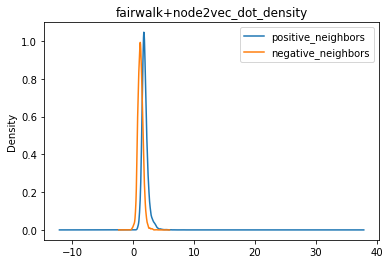

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5223.19it/s]


((6120, 2), 0.003966919159961286, 0.8880269216549445, 0.2609565799259617)

# crosswalk+deepwalk

In [26]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


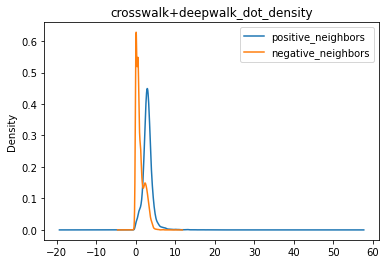

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5373.47it/s]


((6120, 2), 0.004658348961701468, 0.8804365253846029, 0.31098211630661693)

# crosswalk+node2vec

In [29]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


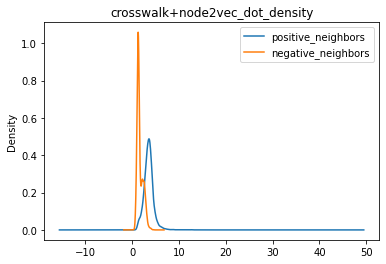

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5088.96it/s]


((6112, 2), 0.004742626151350396, 0.9443951881131123, 0.3048535098439935)

# GCN+deepwalk+random

In [32]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


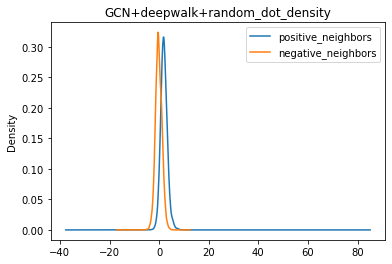

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5453.88it/s]


((6120, 2), 0.004286772894676521, 0.8739282596267505, 0.29094073850038243)

# GCN+deepwalk+r2v

In [35]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12171


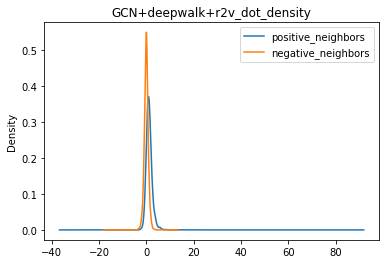

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5844.72it/s]


((6120, 2), 0.003293526268351549, 0.800982572844673, 0.23587087224147776)

# GCN+node2vec+random

In [38]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


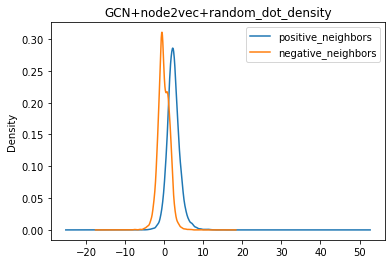

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4652.71it/s]


((6120, 2), 0.00452517784273436, 0.8809757932724904, 0.30614609161359857)

# GCN+node2vec+r2v

In [41]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


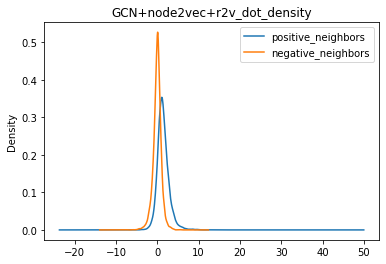

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6400.47it/s]


((6120, 2), 0.003525672349456375, 0.8166419817952948, 0.25006469466859976)

# GAT+deepwalk+random

In [44]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


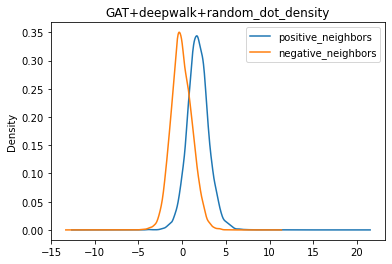

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6095.65it/s]


((6120, 2), 0.004297218052742991, 0.865109978927687, 0.2941246348179414)

# GAT+deepwalk+r2v

In [47]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


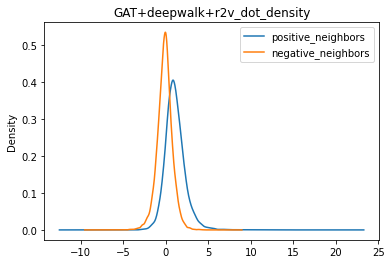

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6127.62it/s]


((6120, 2), 0.0031964534936173043, 0.8102348580896843, 0.2355607714857287)

# GAT+node2vec+random

In [50]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


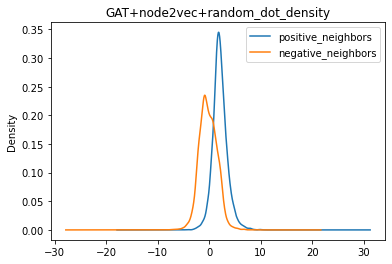

In [51]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [52]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6200.53it/s]


((6120, 2), 0.004447644808980577, 0.8505569523048511, 0.2965538910067456)

# GAT+node2vec+r2v

In [53]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12171


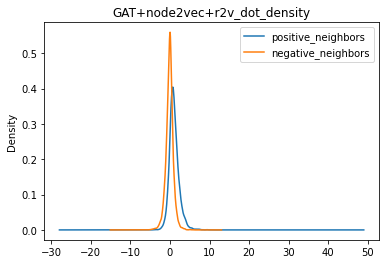

In [54]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [55]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5979.96it/s]


((6120, 2), 0.003549650189448062, 0.787364322907105, 0.2560098324358229)

# plot statistical parity scores

# gini sp scores

word2vec 0.27446417846612314
word2vec+deepwalk+random 0.16094800338836068
deepwalk 0.2927547096109085
node2vec 0.2923689397459116
fairwalk+deepwalk 0.23351528990797066
fairwalk+node2vec 0.2609565799259617
crosswalk+deepwalk 0.31098211630661693
crosswalk+node2vec 0.3048535098439935
GCN+deepwalk+random 0.29094073850038243
GCN+deepwalk+r2v 0.23587087224147776
GCN+node2vec+random 0.30614609161359857
GCN+node2vec+r2v 0.25006469466859976
GAT+deepwalk+random 0.2941246348179414
GAT+deepwalk+r2v 0.2355607714857287
GAT+node2vec+random 0.2965538910067456
GAT+node2vec+r2v 0.2560098324358229


Text(0.5, 1.0, 'gini statistical parity scores')

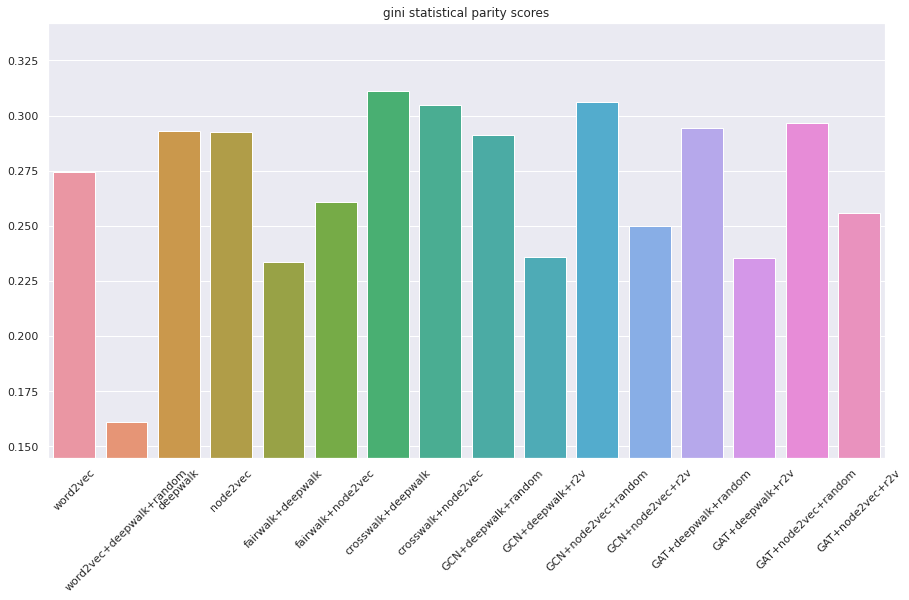

In [56]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

word2vec 0.004016077668200292
word2vec+deepwalk+random 0.002090444147550872
deepwalk 0.004879035413453508
node2vec 0.00479373872687331
fairwalk+deepwalk 0.003558708446888458
fairwalk+node2vec 0.003966919159961286
crosswalk+deepwalk 0.004658348961701468
crosswalk+node2vec 0.004742626151350396
GCN+deepwalk+random 0.004286772894676521
GCN+deepwalk+r2v 0.003293526268351549
GCN+node2vec+random 0.00452517784273436
GCN+node2vec+r2v 0.003525672349456375
GAT+deepwalk+random 0.004297218052742991
GAT+deepwalk+r2v 0.0031964534936173043
GAT+node2vec+random 0.004447644808980577
GAT+node2vec+r2v 0.003549650189448062


Text(0.5, 1.0, 'statistical parity scores')

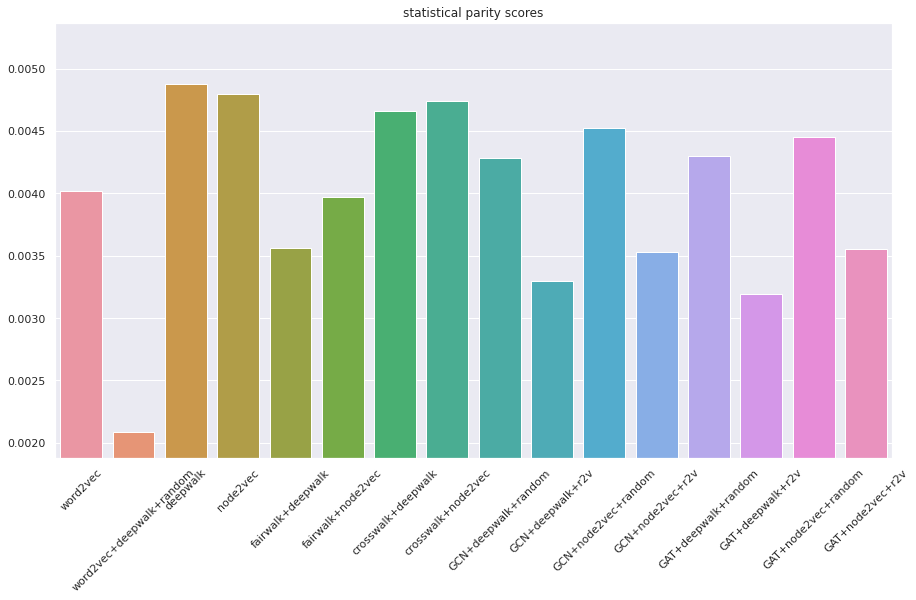

In [57]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

word2vec 0.9830925997224349
word2vec+deepwalk+random 0.7098698090322617
deepwalk 0.8822039274763456
node2vec 0.8740672999924439
fairwalk+deepwalk 0.8575439931136051
fairwalk+node2vec 0.8880269216549445
crosswalk+deepwalk 0.8804365253846029
crosswalk+node2vec 0.9443951881131123
GCN+deepwalk+random 0.8739282596267505
GCN+deepwalk+r2v 0.800982572844673
GCN+node2vec+random 0.8809757932724904
GCN+node2vec+r2v 0.8166419817952948
GAT+deepwalk+random 0.865109978927687
GAT+deepwalk+r2v 0.8102348580896843
GAT+node2vec+random 0.8505569523048511
GAT+node2vec+r2v 0.787364322907105


Text(0.5, 1.0, 'roc scores')

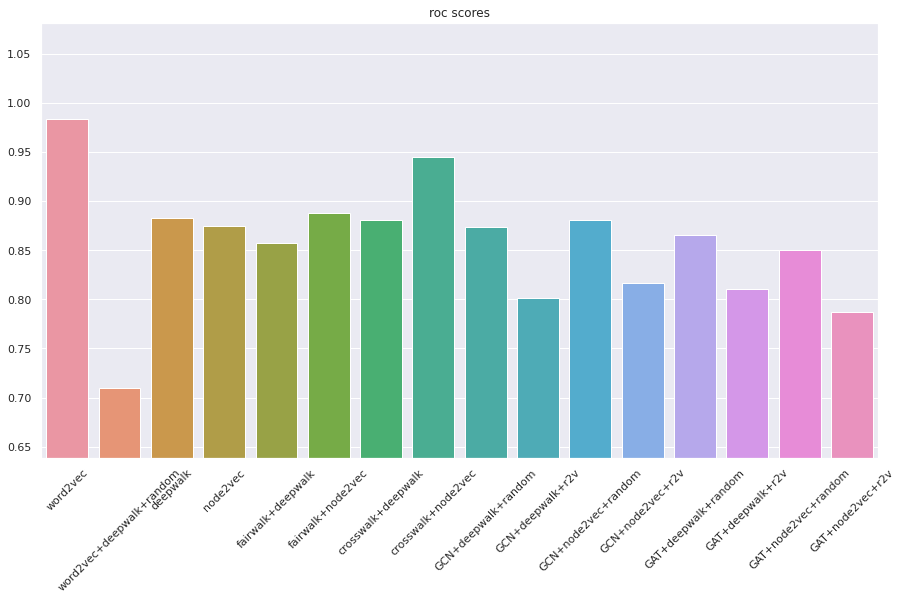

In [58]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [59]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6584.63it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6412.02it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6599.41it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6264.14it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 tra

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6268.90it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6640.35it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6560.49it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6317.66it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5705.39it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6694.73it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6423.13it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6626.07it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6511.24it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6132.32it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6361.64it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6627.27it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6239.39it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6511.24it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6290.17it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6247.77it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 4913.82it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6111.81it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6203.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6362.43it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6460.43it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6703.50it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5872.22it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5836.05it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6486.48it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6303.18it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6105.39it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6647.42it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5681.82it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5782.24it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6024.31it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5202.48it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

Text(0.5, 1.0, 'gini scores vs # nn')

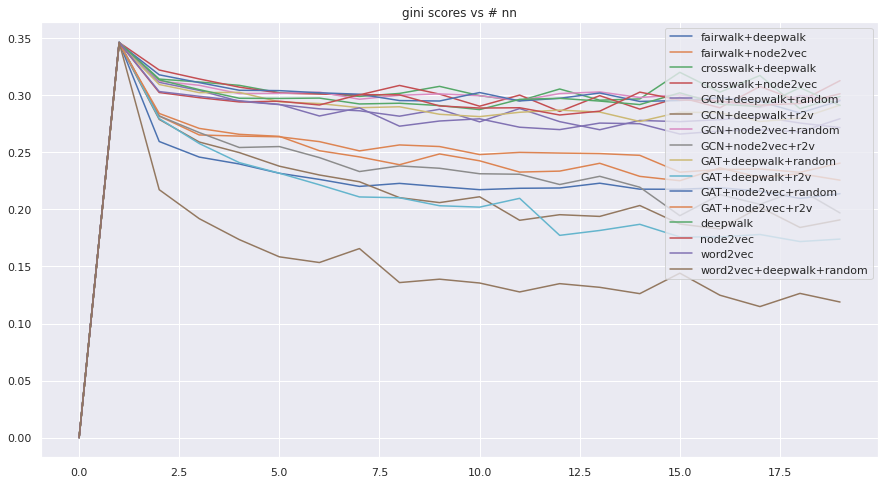

In [60]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

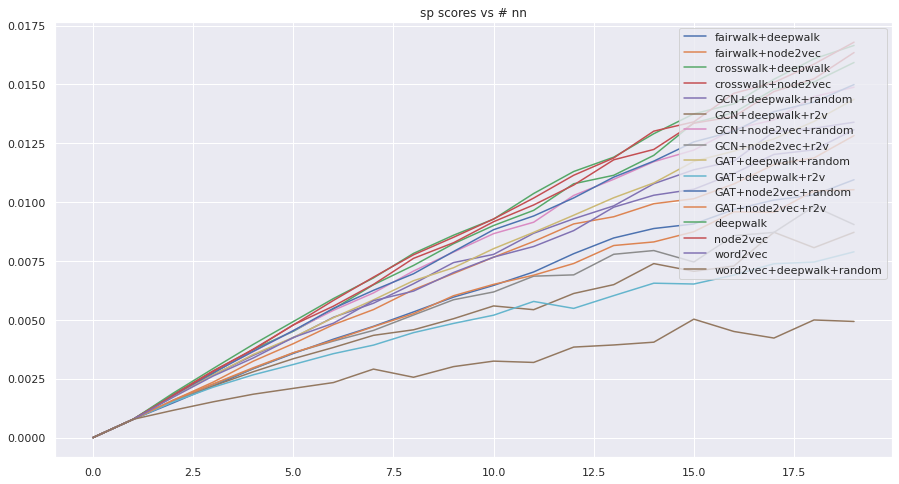

In [61]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [62]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected e

Text(0.5, 1.0, 'roc scores')

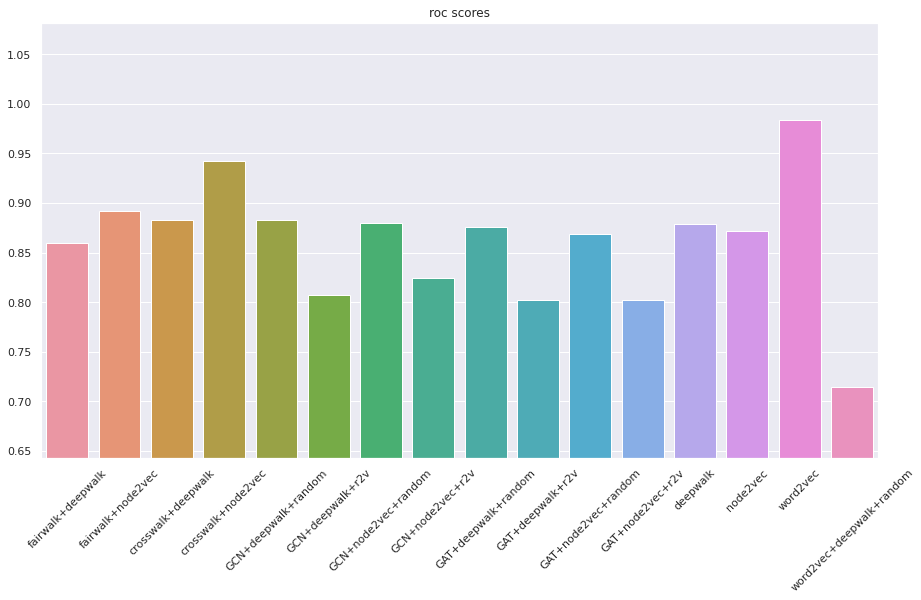

In [63]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6325.16it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5995.79it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6393.76it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6364.65it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 tra

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6472.53it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6422.00it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6245.33it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6086.51it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6589.38it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6351.06it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6799.16it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6487.63it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

fairwalk+deepwalk 0.0036654590028818356
fairwalk+node2vec 0.004013543437842435
crosswalk+deepwalk 0.004694101315224986
crosswalk+node2vec 0.0046935617074934195
GCN+deepwalk+random 0.004378978536511968
GCN+deepwalk+r2v 0.0032363562525532996
GCN+node2vec+random 0.004486857606716839
GCN+node2vec+r2v 0.0036587600613766265
GAT+deepwalk+random 0.004452018913489781
GAT+deepwalk+r2v 0.003078728089647495
GAT+node2vec+random 0.004480487763969481
GAT+node2vec+r2v 0.003606885783231728
deepwalk 0.004940545229736843
node2vec 0.004828043032394676
word2vec 0.004244776998751716
word2vec+deepwalk+random 0.0021134466065204404


Text(0.5, 1.0, 'statistical parity scores')

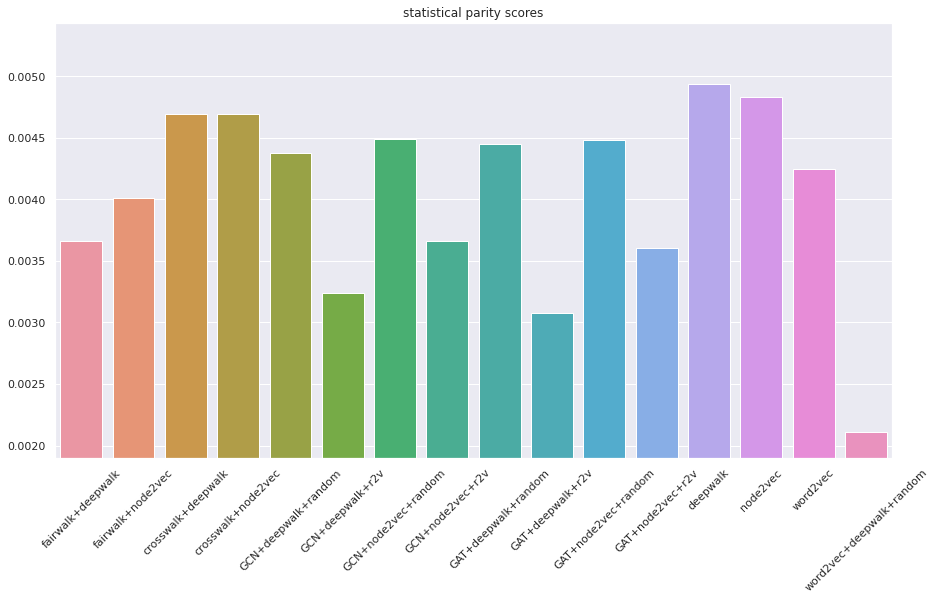

In [64]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.24018570989853033
fairwalk+node2vec 0.26424838439377907
crosswalk+deepwalk 0.3094755524638665
crosswalk+node2vec 0.3038942429394834
GCN+deepwalk+random 0.29852688811567746
GCN+deepwalk+r2v 0.23422032528806383
GCN+node2vec+random 0.300786362008172
GCN+node2vec+r2v 0.25653497739022885
GAT+deepwalk+random 0.30064084238267075
GAT+deepwalk+r2v 0.23010054771346158
GAT+node2vec+random 0.2984031048702038
GAT+node2vec+r2v 0.2546304758083348
deepwalk 0.299546381018
node2vec 0.2946036822056458
word2vec 0.28990433477668565
word2vec+deepwalk+random 0.16613038862066326


Text(0.5, 1.0, 'gini statistical parity scores')

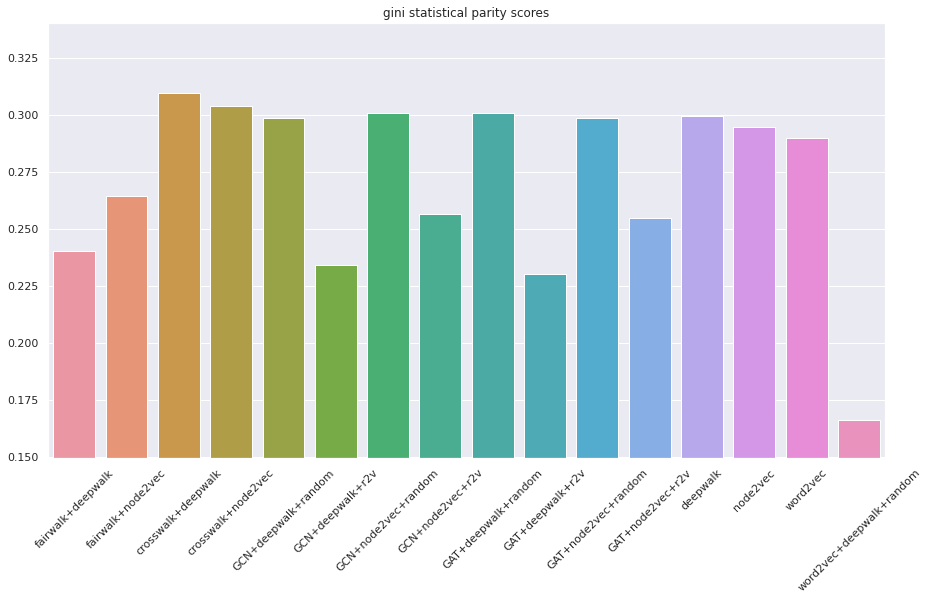

In [65]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [66]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected edge_idx size: 12935
selected edge_idx size: 13038
selected edge_idx size: 12171
selected edge_idx size: 13131
selected edge_idx size: 12151
selected e

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points


selected edge_idx size: 13038


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6453.59it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6412.99it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6176.73it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6374.00it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6466.47it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6372.10it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6759.29it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 6554.27it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5459.93it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5406.17it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5431.77it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 5369.08it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|███████████████████████████████████████████████████████████████████████████